# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(874)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
rho = 0.5
N = 500000
NumberofSources = 5
NumberofMixtures = 10

M = NumberofMixtures
r = NumberofSources
INPUT_STD = 0.28
SNR = 30 # dB
# NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = True)

A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
for MM in range(A.shape[0]):
    stdx = np.std(X[MM,:])
    A[MM,:] = A[MM,:]/stdx * INPUT_STD
X = A @ S
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.0039782498944


# Visualize Generated Sources and Mixtures

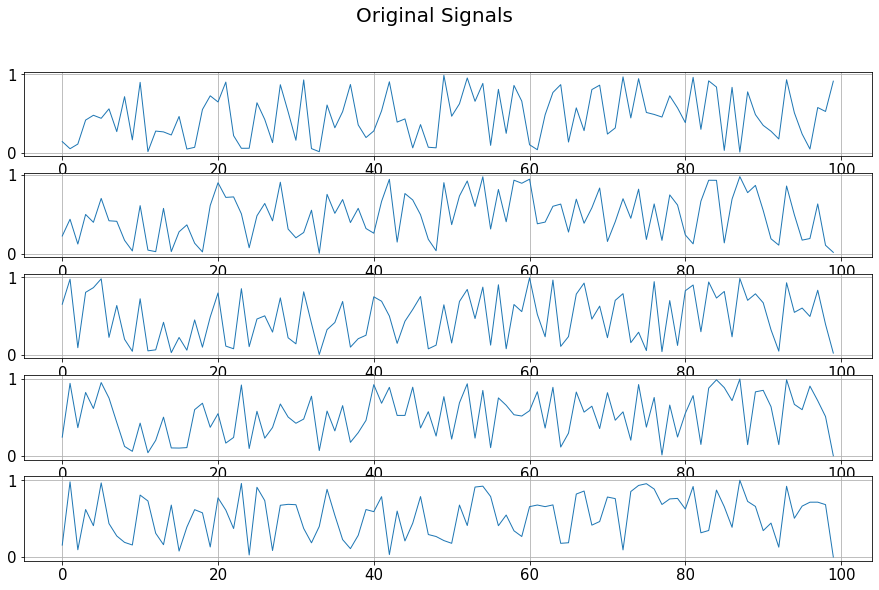

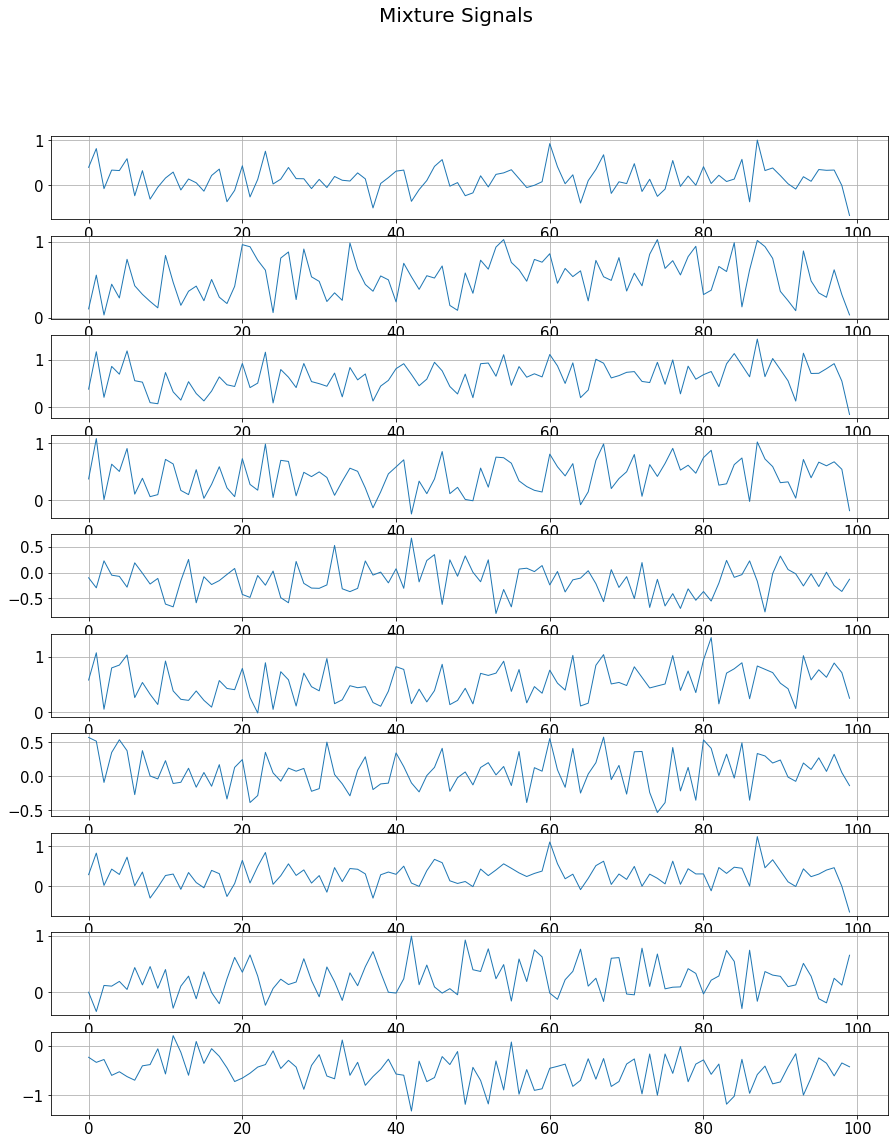

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
if rho > 0.4:
    gamma_start = 0.05
    gamma_stop = 5*1e-4
else:
    gamma_start = 0.1
    gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1e-3,1e-3]
LayerMaximumGains = [1e6,20]
WScalings = [0.0033,0.0033]
GamScalings = [2,1]
zeta = 1*1e-5
beta = 0.5
muD = [1, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# Run WSM Algorithm on Mixture Signals

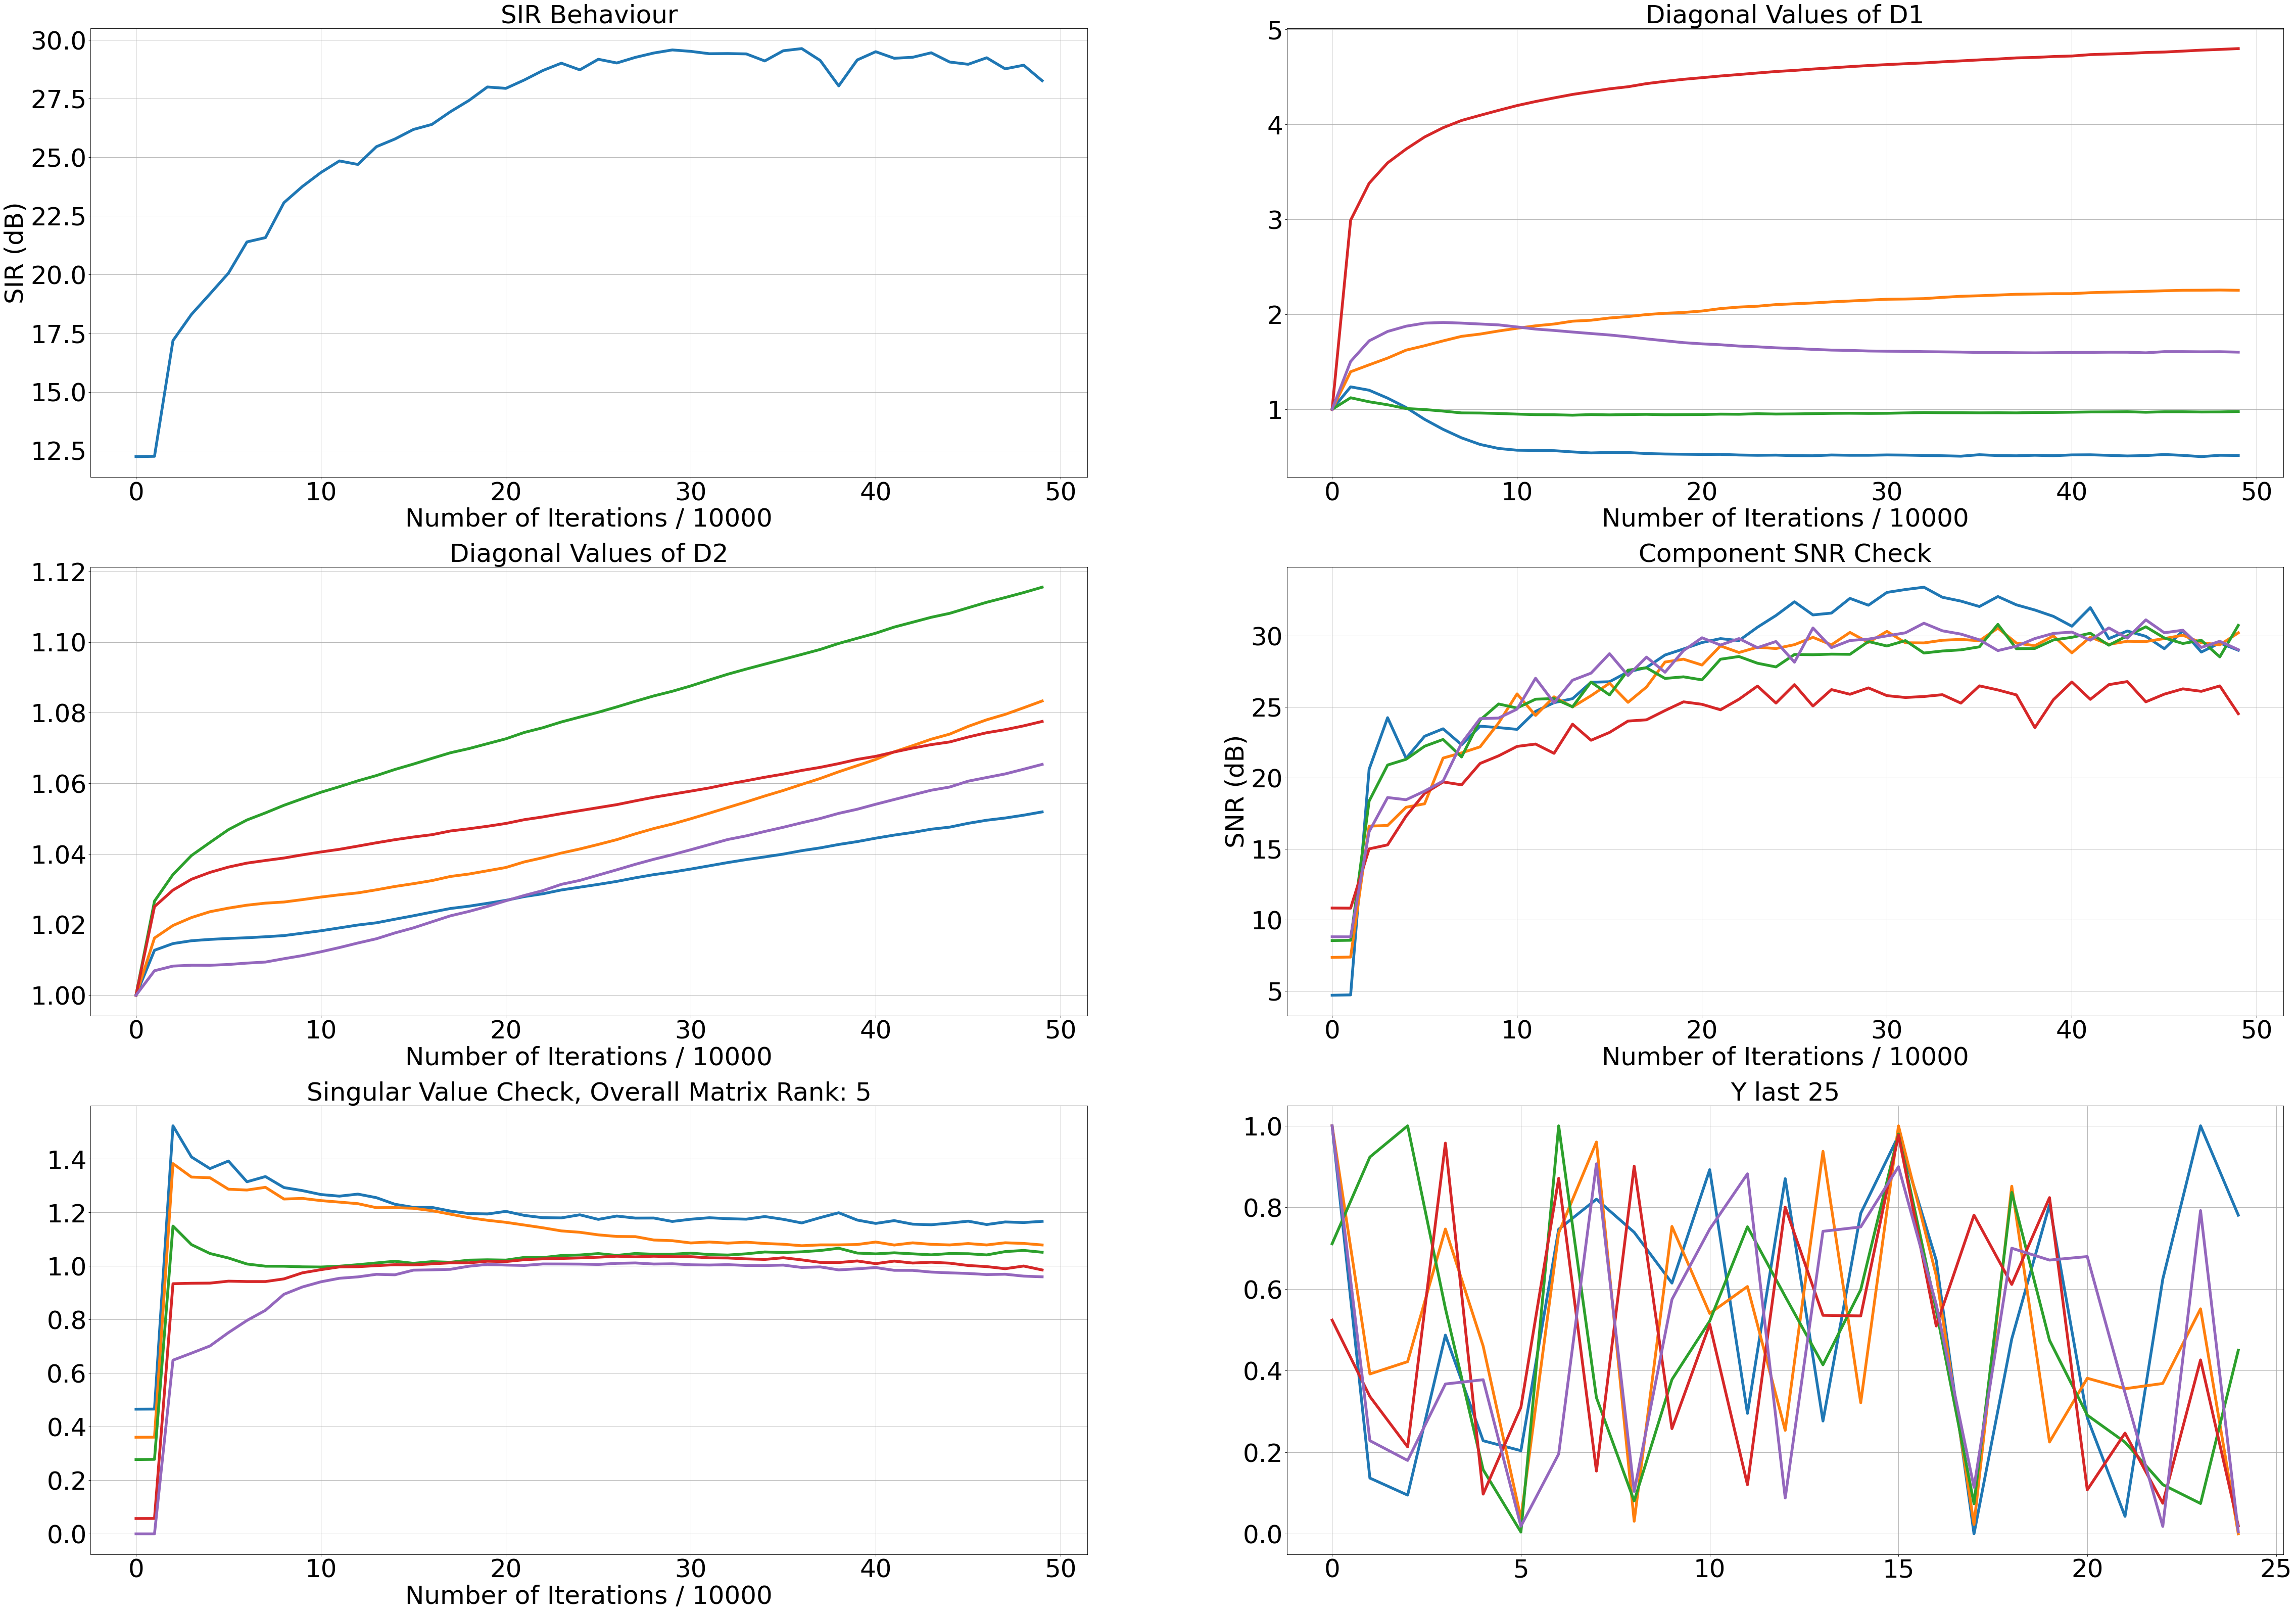

100%|████████████████████████████████████████████████████████████████| 500000/500000 [31:09<00:00, 267.45it/s]


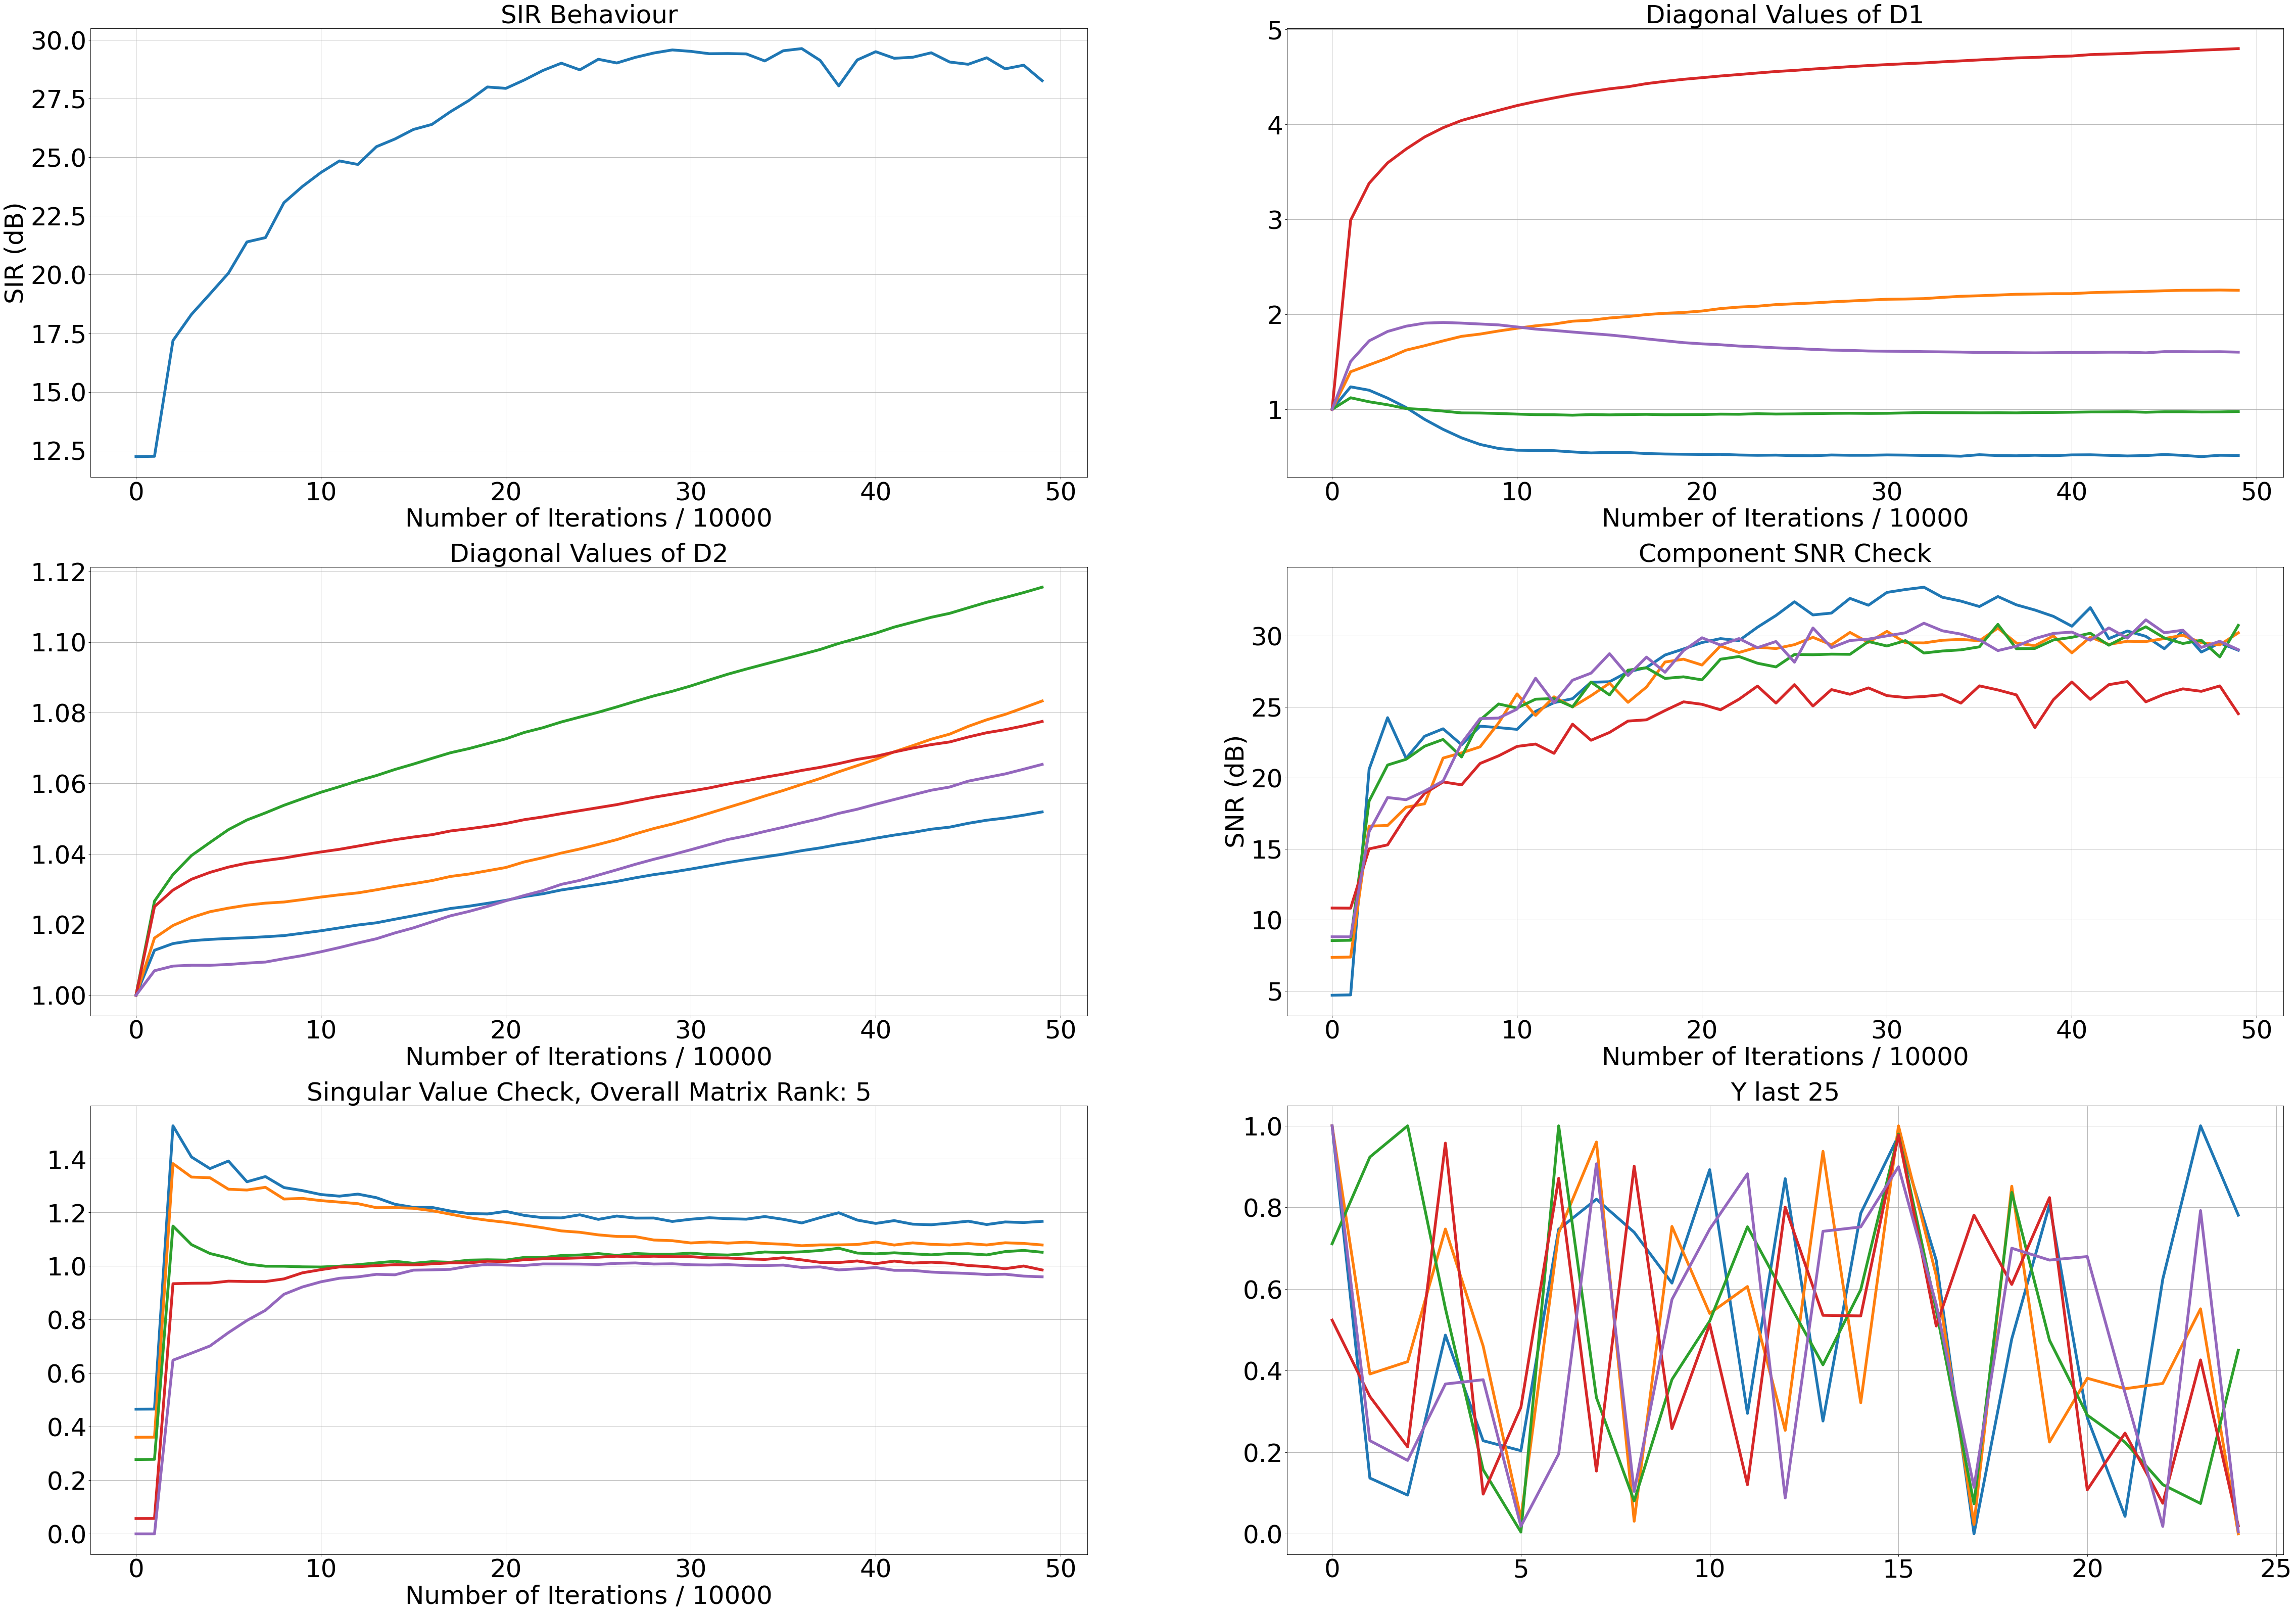

In [6]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = W_HX, W_YH = W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_nnantisparse( X, n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = 0.75,
                                 neural_lr_stop = 0.05,
                                 neural_fast_start = False,
                                 whiten = False,
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True,
                                )

# Visualize SNR Convergence of Each Source Component

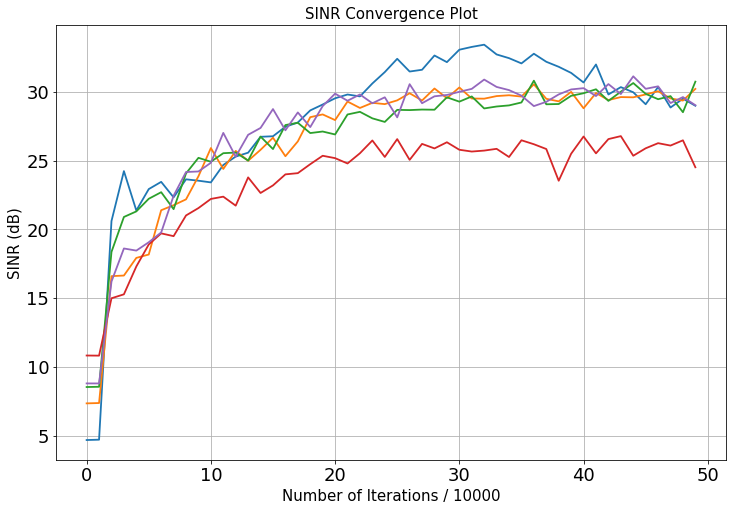

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [27.98802856 29.92322072 29.74454633 25.80648135 30.58031797]

Overall SINR : 28.722503104865474


# Vizualize Extracted Signals Compared to Original Sources

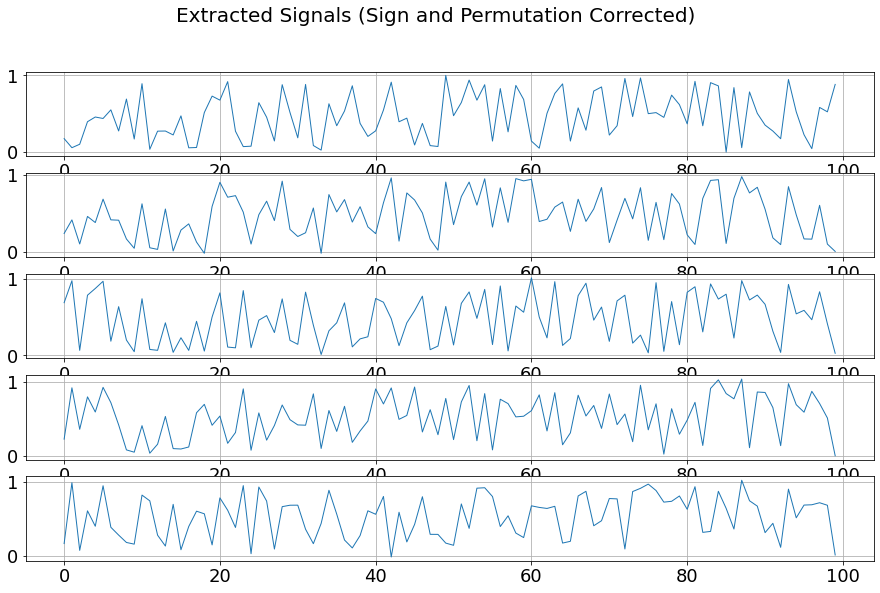

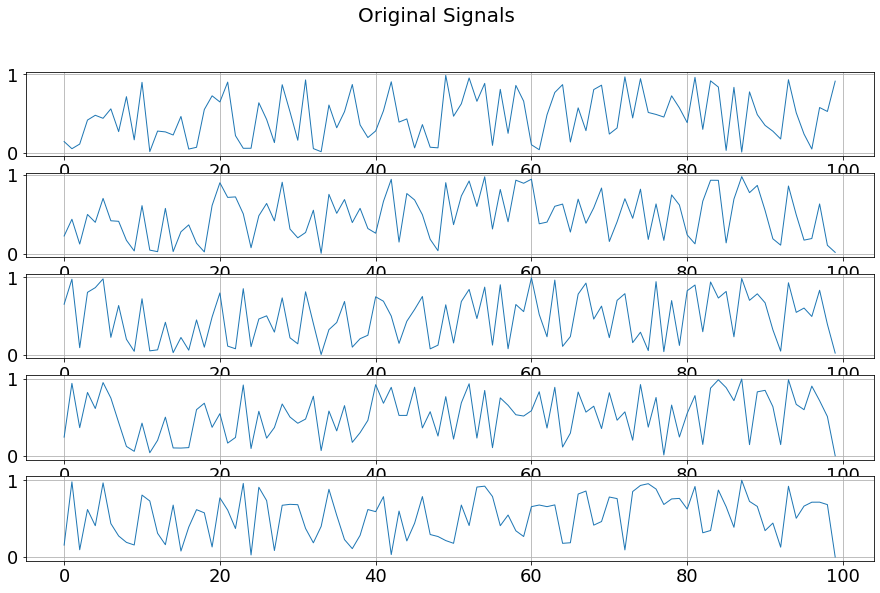

In [9]:
subplot_1D_signals(Y_[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)